Given a mask of <500 voxels with criteria from attentio-spatial condition 0.

Goal 1: Train the model on one of the folds for this condition.

Goal 2: Train the model on 4 X 1-folds of all the 4 conditions.

Decode the stimulus likelihoods of all the attentio-spatial conditions. Obtain the error per frequency and the mean error. Obtain the sigmas. Is there any difference across conditions?

Metrics to measure differences accross conditions:
- non-cross validated model performance.
- error between decoded frequency and true frequency.
- sigma average across all frequencies.

This code has been modified from Gardner's lab tutorial on inverse encoding models.
- https://gru.stanford.edu/doku.php/tutorials/channel
- https://gru.stanford.edu/doku.php/tutorials/channel_full_code

We will use simulated tactile stimuli of frequencies: 100-340 Hz: 100, 130, 160, 190, 220, 250, 280, 310, 340.

#### Created on September 2024 by Daniela del Río, https://github.com/DanidelRio 

The underlying idea is that every voxel (channel responses) is modeled as the linear sum of underlying populations of neurons (channel responses) tuned to different orientations.

The BOLD response for every stimuli is a weighted sum of the channel responses.
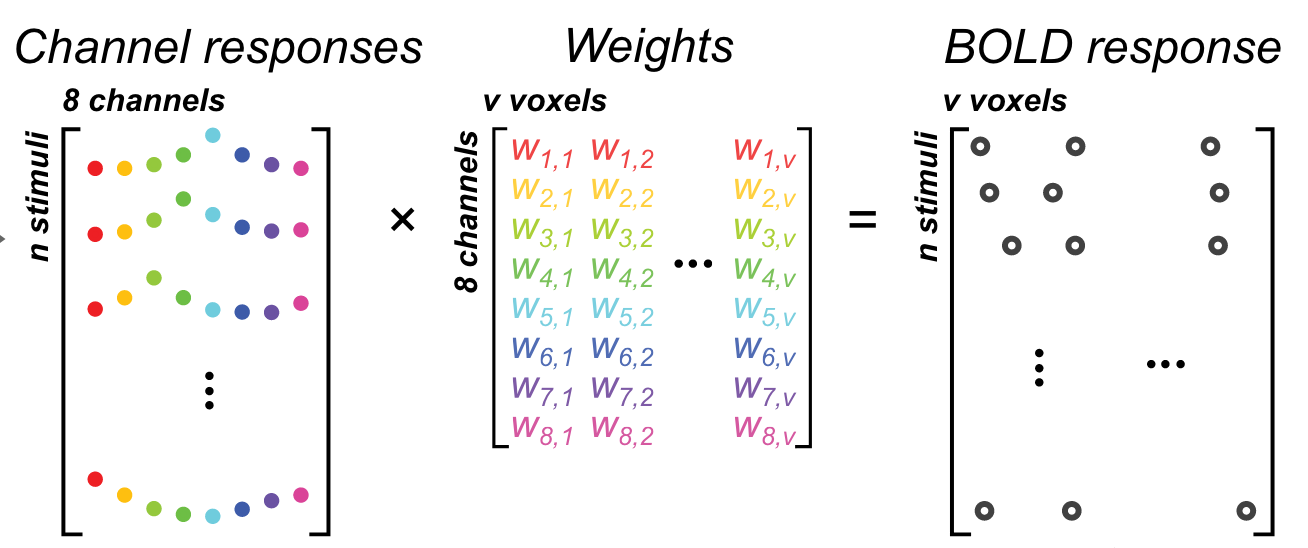

See Gardner and Liu, 2018.

$$C W = B$$

In forward encoding, we know the channel response matrix and the BOLD response matrix. So we solve for the weight matrix. For example, using the least-squares regression.

In inverse encoding, using the BOLD response matrix and an estimated weight matrix, we solve for the channel responses.


### Parts of the channel encoding model tutorial:
1. Simulating data for fitting the model.
    - Obtain channel response (C) and BOLD response (B) matrices.
2. Perform forward encoding.
    - Fitting the weight matrix to the simulated data.
    $$ W = C^\dagger B$$
    
    Question: Why calculate the pseudoinverse of a matrix?
$$C  W = B$$
$$C^\dagger C W = C^\dagger B$$
$$\mathrm(1) W = C^\dagger B$$
$$W = C^\dagger B$$
Note that $C^\dagger$ is the pseudoinverse of C.

3. Computing the goodness-of-fit. $r^2$
4. Inverting the encoding model.
    - Solving for the channel response matrix (C) using the estimated weight matrix (W).
    - Note on cross-validation. Dividing voxel response (B) in 2 parts (train and test voxel response) to test the model's ability to predict new data that was not used in estimating it.
    
    $$C = B W^\dagger$$
5. Use a simplified Bayesian algorithm to determine stimulus likelihood.
    - Stimulus likelihood function is the probability of any stimulus given a particular response. Requirements: mean response and variance around the mean response. This is obtained from the residuals once the encoding model is fitted. For example, fit a multi-variate gaussian noise model to these residuals.
    - Compute the multivariate gaussian probability distribution.
    - Note: The channel responses depend on the basis/kernel we use. In this case, we assumed them to be linear. If we assumed them to be bimodal, that is what we would obtain.

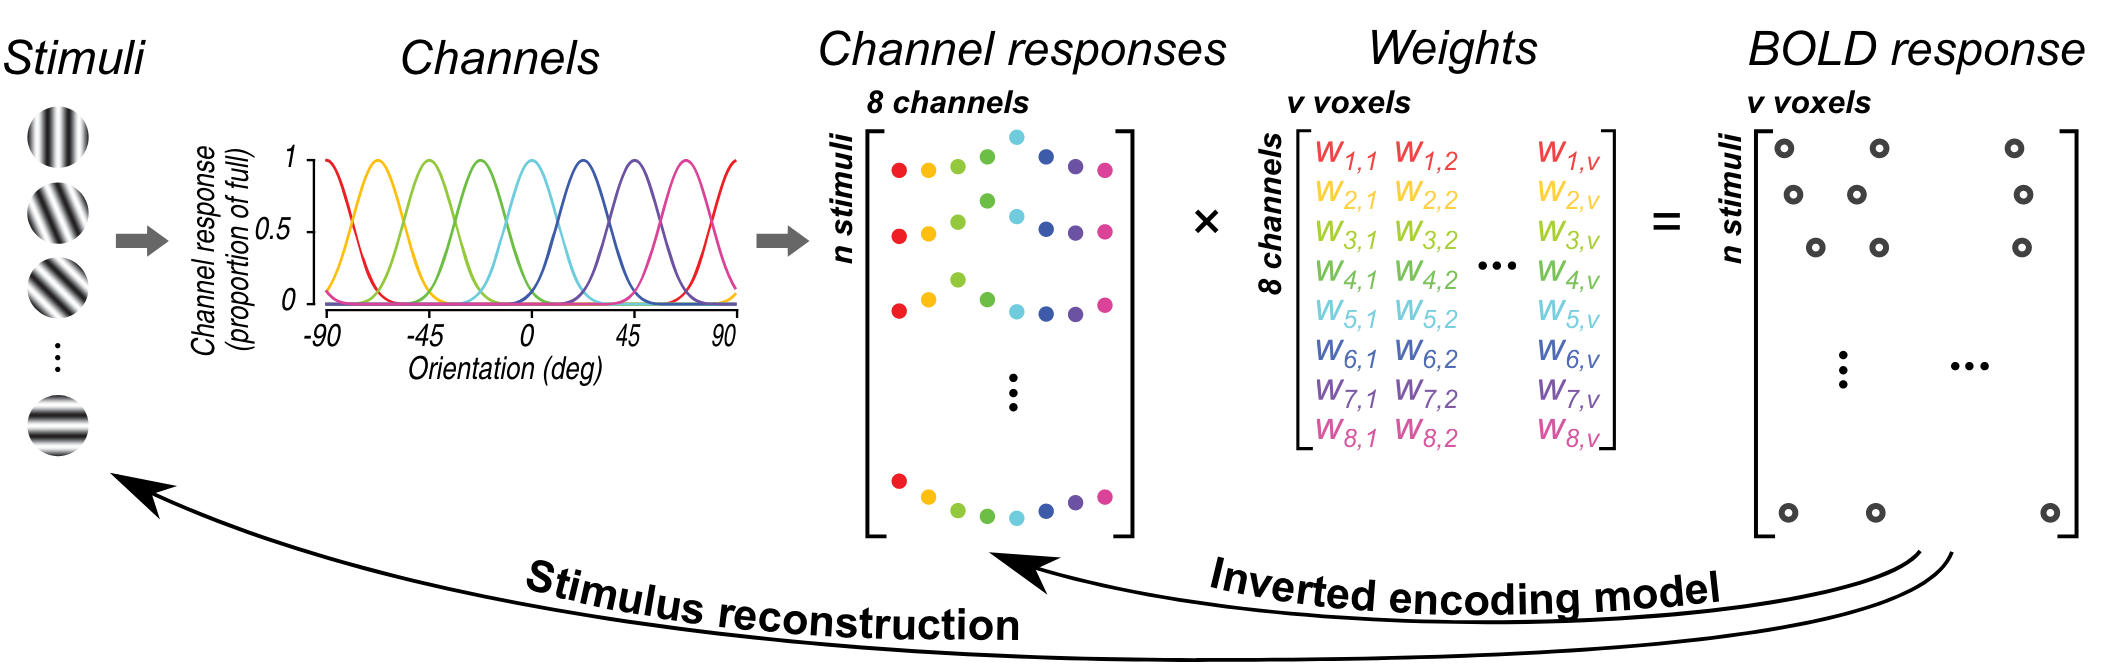
See Gardner and Liu, 2018.


A question that drove the rewriting is: Is it valid to express B as the product of smaller ranked matrices? Is matrix multiplication invariant under matrix decomposition? The answer is: no. Here is another question. Would the analysis followed by Gardner and Liu change anything if the B matrix diminished its rank, that is, we first considered a certain number of voxels and we then considered another number of voxels? Let's look at the ranks

- Channel responses [C]
- Weights [W]
- BOLD response [B]
t-index inticates the division index between train and test trials.

Notation note: $\hat{W}$ indicates the estimated weight matrix, analogous, $\hat{B}$ indicates the predicted BOLD responses.

$$[C] = n-trials \ \times \ k-channels$$
$$[W] = k-channels \ \times \ v-voxels$$
$$[B] = n-trials \ \times \  v-voxels$$

However, the data is divided into trial and test. 
$$[B_1] = t \times v$$
$$[B_2] = n-t \times v$$

Note: The rank of the pseudoinverese is the same as the original matrix, regardless if it's square or not. Let 
$$[A] = n \times m$$
$$[A^\dagger] = m \times n$$



Coming back to the question about first calculating the BOLD response for a fixed number of voxels and then for another number of voxels, yes. That is a valid thing to do.

We know the estimated weight matrix $[\hat{W}]$ is given by:
$$\hat{W} = C^\dagger B_1$$
$$[C^\dagger B_1] \ = \ (n \times v)^\dagger \ (t \times v) \ = \ (n \times t) \ (t \times v) \ = \ n \times v$$
$$[\hat{W}] \ = \ n \times v$$

Now, for the predicted BOLD responses $[\hat{B}]$
$$\hat{B} = C \hat{W}$$
$$[C \hat{W}] \ = \ (n \times k) \ (k \times v) \ = \ n \times v$$
$$[\hat{B}] \ = \ n \times v$$

Cool. Note that we can rewrite $\hat{B}$ in terms of $C$ and $B_1$. Let's do that.
$$\hat{B} = C C^\dagger B_1$$

Additionally, note $C C^\dagger$ do not depend on the number of voxels! Note $n=k$.
$$[C C^\dagger] \ = \ [n \times k] \ [n \times k]^\dagger \ = \ [n \times n]$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import time

from scipy.stats import multivariate_normal, pearsonr, ttest_ind
from scipy.optimize import curve_fit

### Create simulated stimuli, channel responses [C] and BOLD responses [B]

Tactile frequencies: 100, 130, 160, 190, 220, 250, 280, 310 and 340.

In [2]:
# make channel basis functions
# channelResponse C, [nxk]
# channelBasis, C = create_channel_basis(nChannels, exponent, nStimuli, nFolds)

def create_channel_basis(nChannels = 9, exponent = 7, nStimuli = 9):
    # Note in this case, the number of channels is the same as the number of stimuli.

    frequency_range = np.arange(100, 341)
    tactile_stimuli = [i*30+100 for i in range(nStimuli)]
    
    channelBasis = np.zeros((241, nChannels)) # ideal channel responses to each of 210 frequencies
    
    # Creates the channel basis
    for iChannel in range(nChannels):
        # The output of this channel basis might be something different than expected.
        thisChannelBasis =  np.cos(2*np.pi*(frequency_range-tactile_stimuli[iChannel])/360)
        # rectify
        thisChannelBasis[thisChannelBasis<0] = 0
        thisChannelBasis = thisChannelBasis**exponent
        channelBasis[:,iChannel] = thisChannelBasis
        
    # Computes the channelResponse for each stimuli
    C = np.zeros((nStimuli, nChannels))
    
    for iStim in range(nStimuli):
        C[iStim, :] = channelBasis[tactile_stimuli[iStim]-100,:]
        
    return channelBasis, C


# Implementing the inverted encoding model
# Inputs: channelResponse, voxelResponse
def model_fit(C, B_train):
        
    W_estimated = np.matmul(np.linalg.pinv(C), B_train) # Computes the (Moore-Penrose) pseudo-inverse of C1
    B_predicted = np.matmul(C, W_estimated) # model prediction on test data
    
    return W_estimated, B_predicted


# voxelResponse B, [nxv]
# channelResponse C, [nxk]
# Note: channelBasis != channelResponse. The channelResponse is C.

def likelihoods_from_already_trained_model(B_predicted, B_test, nVoxels):
    
    nfrequencies = 241
    nTestTrials = 9
    
    # compute residual
    residualResponse = B_test - B_predicted
    residualVariance = np.var(residualResponse) # a scalar value
    
    # compute r2 for the decoded model. Jeff: Model performance that is not cross-validated.
    r2 = 1 - residualVariance / np.var(B_test)
    
    # Diagonal elements of the matrix are the variance computed across all voxels.
    # Off diagonals (in this case all 0) contain covariance between voxels
    modelCovar = np.identity(nVoxels) * residualVariance
    
    # cycle over each trial
    nTestTrials = np.size(B_test, 0) # n-t
    likelihood = np.zeros([nTestTrials, nfrequencies]) # n-t, 241
    probability = np.zeros([nTestTrials, nfrequencies]) #normalized_likelihood

    for iTrial in range(nTestTrials):

        for iStimulus in range(nfrequencies):
            # compute the mean voxel response predicted by the channel encoding model
            # For the same stimulus, B_predicted is always the same.
            B_every_freq = np.matmul(channelBasis[iStimulus], W_estimated) # 1 X v-voxels
            # The probability of a stimulis is given by the mean response and the model covariance.

            # HERE!! Jeff: the predictedResponse can be expanded in the domain.
            mvnpdf = multivariate_normal.pdf(B_test[iTrial], mean=B_every_freq, cov = modelCovar)
            likelihood[iTrial,iStimulus] = mvnpdf
            
    # Obtaining probability vector, aka normalizing likelihood across trials
    for trial_i in range(nTestTrials):

        upper_lim = max(likelihood[trial_i,:])
        lower_lim = min(likelihood[trial_i,:])

        # Normalization of the likelihood. It is undefined when: upper_lim = lower_lim
        probability[trial_i,:] = (likelihood[trial_i,:]-lower_lim) / (upper_lim-lower_lim)

    
    return r2, likelihood, probability

# Used to fit a gaussian to each trial.
def gaussian(x, mu, sigma, amplitude):
    coefficient = amplitude/ np.sqrt(2*np.pi*sigma**2)
    return coefficient*np.exp(-(x-mu)**2/(2*sigma**2))


# Function that given a vector, replicates the first 50 and last 50 entries of the array.
# The vector should be at least length 100
# Used as a supplementary to `curve_fit`
def mirror_edges(vector, cushion=10):
    
    length = len(vector)
    
    if length < cushion*2:
        print("Vector less than 100 entries")
        
    else:
        beginning = np.flip(vector[0:cushion])
        ending = np.flip(vector[length-cushion:length])
        
    return np.concatenate((beginning, vector, ending))


# Inputs nfrequencies
def gaussian_fit(probability, cushion = 10):

    # Fitting a gaussian to all the test trials
    nTestTrials, nfrequencies = probability.shape

    xdata = [i-cushion for i in range(nfrequencies+cushion*2)] # 211 frequencies, 100-310
    xdata_real = [i+100-cushion for i in range(nfrequencies+cushion*2)] # 211 frequencies, 100-310

    means_vec = np.zeros(nTestTrials)
    sigmas_vec = np.zeros(nTestTrials)
    amplitudes_vec = np.zeros(nTestTrials)

    for trial_i in range(nTestTrials): # 90 iterations. THESE INDICES SHOULD SPAN THE ACTUAL SPACE
        ydata = probability[trial_i, :]
        ydata_mirror = mirror_edges(probability[trial_i,:]) # CONCATENATED VECTOR IN THE EDGES.
        # Jeff Note: mirroring the probability in the edges destroys the noise effects

        p0 = [probability[trial_i,:].argmax(), 0.5, 1] # initial guess

        try:
            # Using non-lionear least squares to fit the data
            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
            fit_gauss = curve_fit(gaussian, xdata, ydata_mirror, p0)
            # gaussian takes: x, mu, sigma, amplitude
        except RuntimeError:
            print("Error fitting gaussian in: ",trial_i)
            fit_gauss = [['nan', 'nan', 'nan']]

        means_vec[trial_i], sigmas_vec[trial_i], amplitudes_vec[trial_i] = fit_gauss[0]

    return means_vec, sigmas_vec, amplitudes_vec

In [3]:
# Function that obtains the relative distance between the values xx and yy, i.e. a divergence function.
# The relative error is pondered by the interval of maximum and minimum values vary across the 2 folds.
# xx and yy are 1-dimensional vectors with 9 entries (frequencies)
def relative_error(xx, yy):
    all_entries = np.concatenate((xx, yy))
    
    maximum = np.max(all_entries)
    minimum = np.min(all_entries)
    
    relative_error = [np.abs(xx[i]-yy[i])/(maximum-minimum) for i in range(len(xx))]    
    
    return np.mean(relative_error)

In [4]:
# Given 2 folds of the data and some exclusion criteria,
# finds the voxels that meet this criteria.
def mask_creation(m1, m2, exclusion_criteria_pearson = 0.7, exclusion_criteria_relative = 0.8):

    length = m1.shape[0]

    absolute_err_vec = [np.mean(np.abs(m1[i] - m2[i])) for i in range(length)]
    absolute_err_1_vec = [1-np.mean(np.abs(m1[i] - m2[i])) for i in range(m1.shape[0])]
    relative_err_vec = [relative_error(m1[i], m2[i]) for i in range(length)]
    relative_err_1_vec = [1-(relative_err_vec[i]) for i in range(length)]
    pearson_cross_correlation = [pearsonr(m1[i], m2[i])[0] for i in range(length)]

    indices_pearson = []
    indices_relative = []
    indices_both = []

    mask_both = [False for i in range(length)]
    mask_pearson_only = [False for i in range(length)]
    mask_relative_only = [False for i in range(length)]

    for i in range(length):

        if pearson_cross_correlation[i] > exclusion_criteria_pearson: # voxel is included in mask_both or mask_pearson_only
            indices_pearson.append(i)

            if relative_err_1_vec[i] > exclusion_criteria_relative: # voxel meets both criteria.
                indices_relative.append(i)
                indices_both.append(i)
                mask_both[i] = True

            else: # voxel only meets Pearson criteria.
                mask_pearson_only[i] = True

        if relative_err_1_vec[i] > exclusion_criteria_relative: # voxel is not considered in a traditional analysis!
            indices_relative.append(i)
            mask_relative_only[i] = True

    print("Number of included voxels that meet both criteria:",len(indices_both))

    return mask_both

In [5]:
# # Create a function that detects peaks. How many peaks are there per condition?
# def peak_detection(vec, threshold=0.1):
    
#     banner = False
#     peaks_i = 0
    
#     for i in range(len(vec)):
        
#         if vec[i] > threshold:
#             if banner == False: # There is only 1 peak when the threshold is surpassed
#                 peaks_i +=1
#                 banner = True
                
#         elif vec[i] < threshold and banner== True: # Resetting the banner.
#             banner = False
#     return peaks_i

# Given some data, mask generation.
This mask will be used for the 3 goals of this notebook.

In [6]:
# # All the data is here!
# subj = 'Data_betas/Betas/FreqAP02'
# hand = 'L'
# # vox1 = np.load(subj+'_N1L1.npy')
# # vox2 = np.load(subj+'_N1L2.npy')

# matrix1 = np.load(subj+'_N1L1.npy')
# matrix2 = np.load(subj+'_N1L2.npy')

In [7]:
# THis is only the first 20000 datapoints
data = np.load('Data_betas/Betas/FreqAP02_L_1.npz') # 20000 datapoints from fold 1 and 20000 from fold 2
lst = data.files

matrix1 = data['arr_0'] # array with beta coefficients, fold 1
matrix2 = data['arr_1'] # array with beta coefficients, fold 2
    
data.close()

In [8]:
# Creating a mask based on condition 0
condition = 0 # Out of 4 conditions

m1_c0 = matrix1[:, 9*condition:9*(condition+1)]
m2_c0 = matrix2[:, 9*condition:9*(condition+1)]

exclusion_criteria_pearson = 0.7
exclusion_criteria_relative = 0.75

mask_both = mask_creation(m1_c0, m2_c0, exclusion_criteria_pearson, exclusion_criteria_relative)

/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Number of included voxels that meet both criteria: 268


# Training the model.

In [9]:
# training the model on one of these 2 folds,

# Initializing variables
nStimuli = 9
nFolds = 1 # These are the number of overall BOLD coefficients in the big matrix. At least the same as nFolds.
# nNeurons = 120
# sigma = 10
# noiseStandardDeviation = 0.1 # 0.4
nVoxels = m1_c0[mask_both].shape[0] # number of voxels

nChannels = 9 # Note how in this particular case, nStimuli = nChannels = 8
exponent = 7

nfrequencies = 241
initial_frequency = 100
print("nVoxels", nVoxels)

B_train = m1_c0[mask_both].T # trainVoxelResponse (B1) [txv]


# Simulating tactile stimuli
tactile_stimuli = [i*30+initial_frequency for i in range(nStimuli)]
stimuli = np.asarray([tactile_stimuli[i//2] for i in range(len(tactile_stimuli)*2)])

frequency_range = np.arange(initial_frequency, initial_frequency+nfrequencies) # Neurons tuned from 100-340 Hz frequencies


channelBasis, C = create_channel_basis(nChannels, exponent, nStimuli)
print("Data ready.")
W_estimated, B_predicted = model_fit(C, B_train)
print("Model fit ready.")

nVoxels 268
Data ready.
Model fit ready.


In [10]:
def simulation(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency):
    # Running the simulation
    start_time = time.time()
    # How much time is this taking to run? https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution

    C_estimated = np.matmul(B_test, np.linalg.pinv(W_estimated)) # estimated channel responses from B2
    r2, likelihood, probability = likelihoods_from_already_trained_model(B_predicted, B_test, nVoxels)

    means_vec, sigmas_vec, amplitudes_vec = gaussian_fit(probability, cushion = 10)
    print("Gaussian fit ready.")

    average_error_per_condition = np.zeros(nStimuli)
    error = np.abs(tactile_stimuli-(means_vec+initial_frequency))

    for i in range(nStimuli):
        error_no_nans_i = error[i][~np.isnan(error[i])] # Removes nans
        # https://stackoverflow.com/questions/11620914/how-do-i-remove-nan-values-from-a-numpy-array
        # Note: removing nans destroys the 9*10 array structure, converting it to a big array.
        average_error_per_condition[i] = np.mean(error_no_nans_i)
    print("Error calculation ready.")

    simulation_time = time.time() - start_time

    print("--- %s seconds ---" % simulation_time) # Converts any value into a string.
    
    return C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, average_error_per_condition

# Goal 1: Train the model on one of the folds for this condition.

### Condition 0

In [11]:
B_test = m2_c0[mask_both].T # testVoxelResponse (B2) [txv]

# Note the model accepts the B matrix where the BOLD coefficients for the same trial
# condition are consecutive. So we have to change the shape of this `m1` and `m2` to satisfy this condition.
# `[B] = nStimuli*nRepeats, nVoxels` alternating the value of one fold with the value for that same trial of the other fold.
B = np.array([
    [B_test[i//2][k] if i % 2 == 0 else B_train[i//2][k] for i in range(B_test.shape[0] * 2)]
    for k in range(B_train.shape[1])]).T
print(B.shape) # Should be 18*268


C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, average_error_per_condition = simulation(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency)

(18, 268)
Gaussian fit ready.
Error calculation ready.
--- 9.473789930343628 seconds ---


In [12]:
# # Creating a mask based on condition 0
# condition = 1 # Out of 4 conditions

# m1_c1 = matrix1[:, 9*condition:9*(condition+1)]
# m2_c1 = matrix2[:, 9*condition:9*(condition+1)]

# Plotting every step of the simulation.

In [13]:
def initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec):
    # Obtain the similarity plot
    nTrials = B.shape[0]
    matrix = np.zeros([nTrials, nTrials])

    for i in range(nTrials):
        for j in range(nTrials):
            matrix[i, j] = pearsonr(B[i,:], B[j,:])[0]    
            
    plt.figure(figsize=(8, 6), dpi=80)
    plt.imshow(matrix)
    plt.show()
    
    # # Decoding Model Accuracy and Estimated Channel Responses
    #Neural noise is between 0.4 and 0.5 in the model we were playing with to replicate
    #this level of r^2 decoding accuracy (see notes Thu, Sep 12).
    print("Model performance that is not cross-validated",r2)

    # I expect to see 9 peaks in this graph.
    plt.plot(C_estimated)
    plt.xlabel('n-stimuli')
    plt.ylabel('Channel response')
    plt.title('Estimated Channel Response') # [B2 * W_estimated^T] = n-t * k
    plt.show()
    
    plt.figure(figsize=(16, 8))
    plt.imshow(probability)
    plt.xlabel('Stimulus frequency -100 [Hz]')
    plt.ylabel('Ordered trial #')
    plt.title('Probability')
    plt.show()
    
    plt.plot(means_vec)
    plt.title("Means")
    plt.xlabel('Trial #')
    plt.ylabel('Gaussian mean (most likely orientation [deg])')
    plt.show()

    plt.plot(sigmas_vec)
    plt.title("Sigmas")
    plt.xlabel('Trial #')
    plt.ylabel('Gaussian stdev (most likely sigma)')
    plt.show()

    plt.plot(amplitudes_vec)
    plt.title("Amplitude")
    plt.xlabel('Trial #')
    plt.ylabel('Gaussian amplitude (most likely amplitude)')
    plt.show()

    # In the 340 Hz trials, the sigmas have higher values.
    # This might be related to the estimatedChannelResponses?
    #The lower sigmas for 100 and 310 Hz might be some kind of border effect?
    return None


def other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, average_error_per_condition):

    trials = [i for i in range(9)]
    all_freq_stimuli = [i+initial_frequency for i in range(241)]
    xdata = [i for i in range(241)]

    for trial_i in range(len(trials)):

        mean, sigma, amplitude = means_vec[trial_i], sigmas_vec[trial_i], amplitudes_vec[trial_i]
        label_Hz = str(round(mean) + initial_frequency)

        plt.plot(all_freq_stimuli, probability[trial_i,:], marker=".", c="k")
        plt.plot(all_freq_stimuli, gaussian(xdata, mean, sigma, amplitude),  label=label_Hz)

        plt.title("Gaussians for all the trials")
        plt.xlabel('Stimulus frequency [Hz]')
        plt.ylabel('Likelihood')
        plt.legend(bbox_to_anchor=(0.5, 0.5, 1, 0.5), title="Frequencies [Hz]")

    plt.show()


    plt.scatter(tactile_stimuli, sigmas_vec, c="k")
    plt.hlines(np.mean(sigmas_vec), tactile_stimuli[0], tactile_stimuli[len(tactile_stimuli)-1],
               linestyle='dashed', colors = 'r')
    plt.ylabel("Sigma (from gaussian fit)")
    plt.xlabel('Trial #')
    plt.title('Mean sigma (from gaussian fit) '+str(np.round(np.mean(sigmas_vec), 2)))
    plt.show()


    # Calculating the error of the fitted gaussian's mean compared to the real frequency.
    plt.scatter(tactile_stimuli, average_error_per_condition, c="k")#, label=label_Hz)
    plt.hlines(np.mean(average_error_per_condition), tactile_stimuli[0], tactile_stimuli[len(tactile_stimuli)-1],
               linestyle='dashed', colors = 'r')
    plt.xlabel(r'Decoded Frequency [Hz]')
    plt.ylabel(r'Average error per condition')    
    plt.title("Mean Error "+str(np.round(np.mean(average_error_per_condition), 2)))
    plt.show()

    return None

## Voxel Response

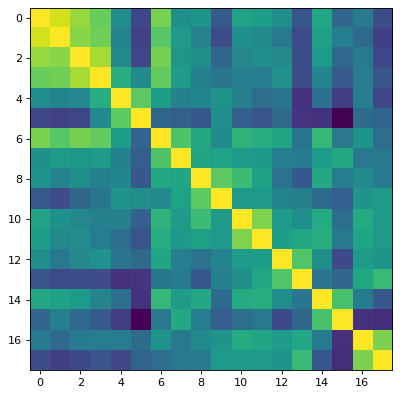

Model performance that is not cross-validated 0.6995348720377972


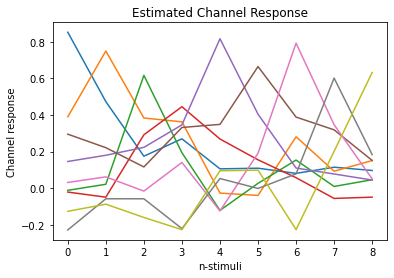

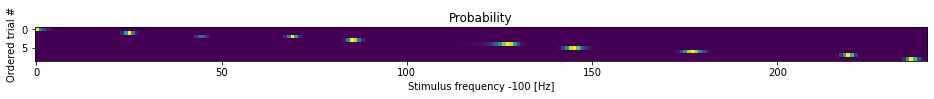

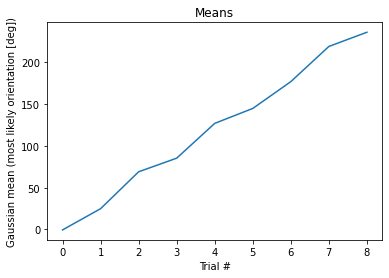

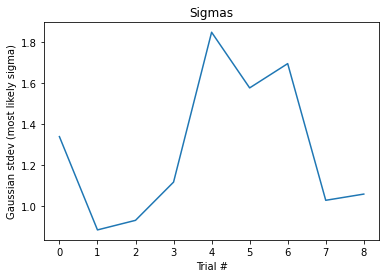

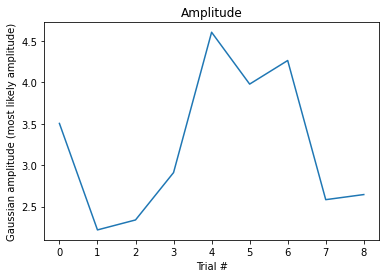

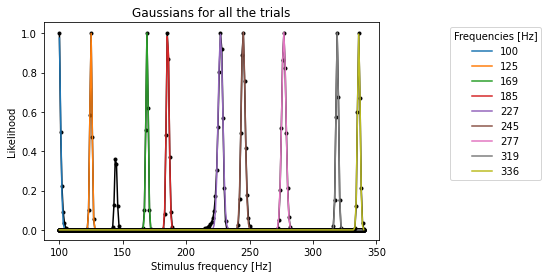

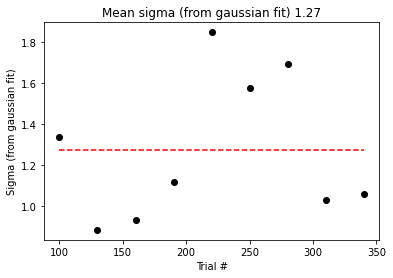

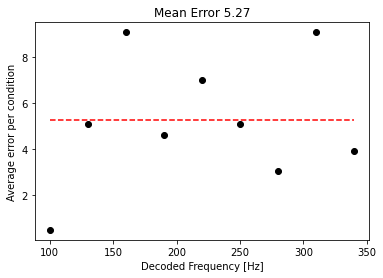

In [14]:
initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec)
other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, average_error_per_condition)

### Condition 1

In [15]:
# B_test data
condition = 1
m1_c1 = matrix1[:, 9*condition:9*(condition+1)]
m2_c1 = matrix2[:, 9*condition:9*(condition+1)]

condition = 2
m1_c2 = matrix1[:, 9*condition:9*(condition+1)]
m2_c2 = matrix2[:, 9*condition:9*(condition+1)]

condition = 3
m1_c3 = matrix1[:, 9*condition:9*(condition+1)]
m2_c3 = matrix2[:, 9*condition:9*(condition+1)]

# B_test1 = m1_c1[mask_both].T # testVoxelResponse (B2) [txv]
# B_test2 = m1_c2[mask_both].T # testVoxelResponse (B2) [txv]
# B_test3 = m1_c3[mask_both].T # testVoxelResponse (B2) [txv]

# # Note the model accepts the B matrix where the BOLD coefficients for the same trial
# # condition are consecutive. So we have to change the shape of this `m1` and `m2` to satisfy this condition.
# # `[B] = nStimuli*nRepeats, nVoxels` alternating the value of one fold with the value for that same trial of the other fold.
# B_test = np.array([
#     [B_test1[i//3][k] if i % 3 == 0 else B_test2[i//3][k] if i % 3 == 1 else B_test3[i//3][k]
#      for i in range(B_test1.shape[0] * 3)]
#     for k in range(B_test1.shape[1])]).T
# print(B_test.shape) # Should be 18*268

# B_test = np.array([
#     [B_test1[i//2][k] if i % 2 == 0 else B_test2[i//2][k] for i in range(B_test1.shape[0] * 2)]
#     for k in range(B_test1.shape[1])]).T
# print(B_test.shape) 

(18, 268)
Gaussian fit ready.
Error calculation ready.
--- 9.419538259506226 seconds ---


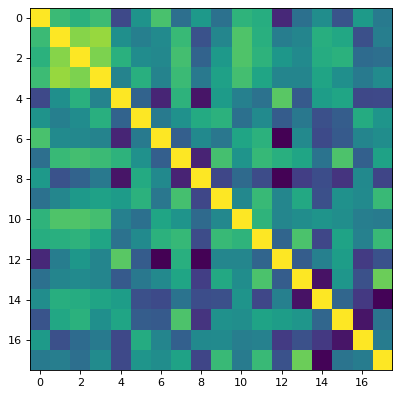

Model performance that is not cross-validated -0.2175391054361122


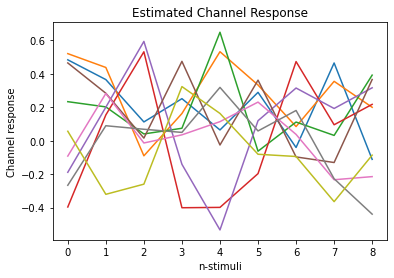

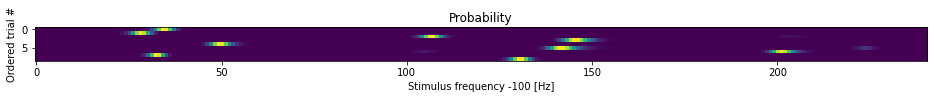

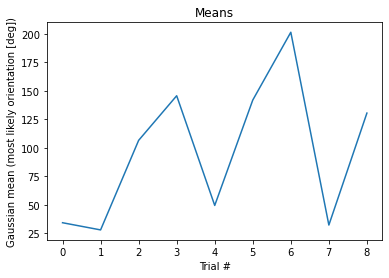

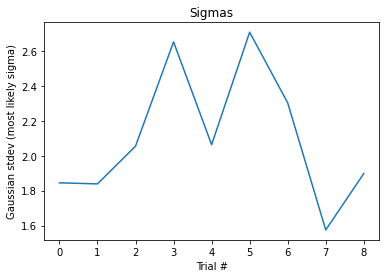

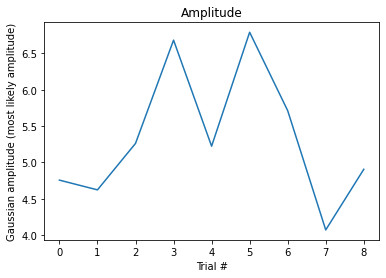

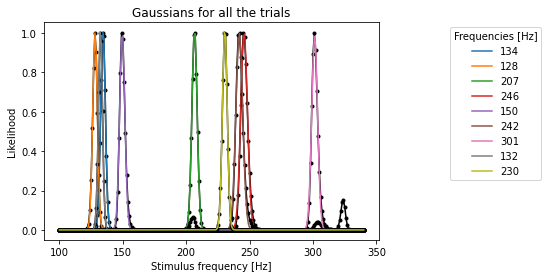

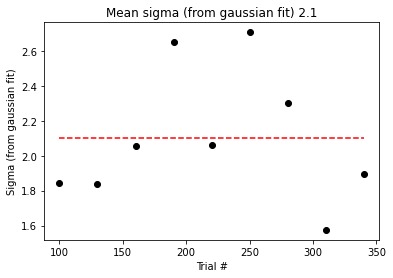

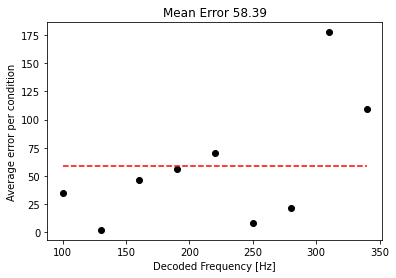

In [16]:
# Condition 1
B_test = m1_c1[mask_both].T # testVoxelResponse (B2) [txv]

# Note the model accepts the B matrix where the BOLD coefficients for the same trial
# condition are consecutive. So we have to change the shape of this `m1` and `m2` to satisfy this condition.
# `[B] = nStimuli*nRepeats, nVoxels` alternating the value of one fold with the value for that same trial of the other fold.
B = np.array([
    [B_test[i//2][k] if i % 2 == 0 else B_train[i//2][k] for i in range(B_test.shape[0] * 2)]
    for k in range(B_train.shape[1])]).T
print(B.shape) # Should be 18*268


C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, average_error_per_condition = simulation(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency)

initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec)
other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, average_error_per_condition)

(18, 268)
Gaussian fit ready.
Error calculation ready.
--- 16.121011972427368 seconds ---


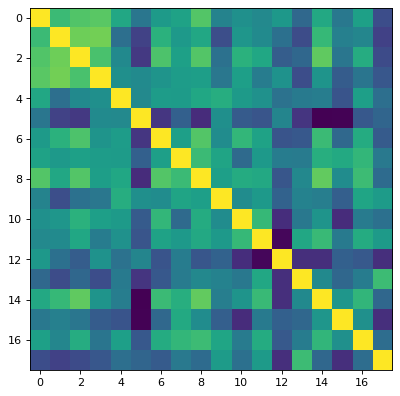

Model performance that is not cross-validated 0.2815837794825887


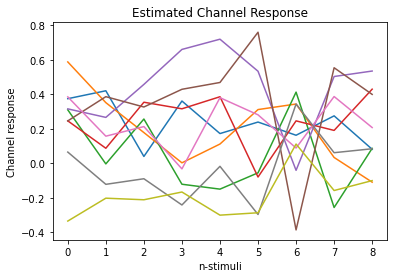

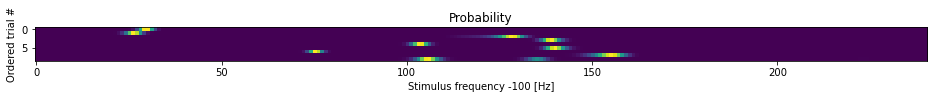

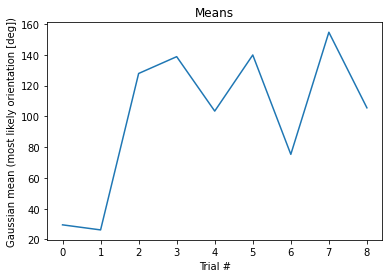

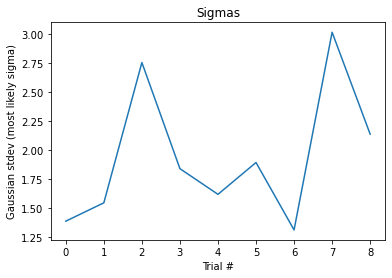

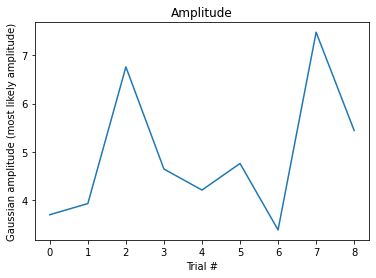

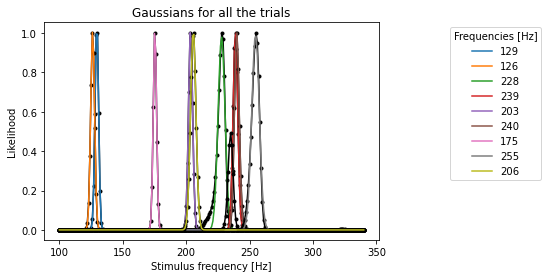

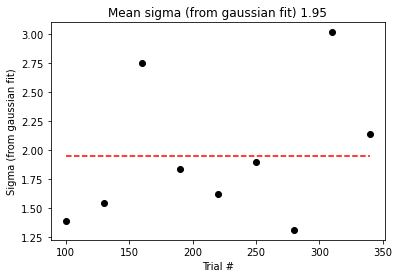

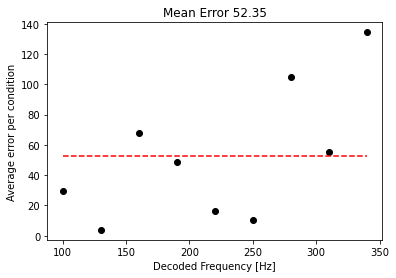

In [17]:
# Condition 2
B_test = m1_c2[mask_both].T # testVoxelResponse (B2) [txv]

# Note the model accepts the B matrix where the BOLD coefficients for the same trial
# condition are consecutive. So we have to change the shape of this `m1` and `m2` to satisfy this condition.
# `[B] = nStimuli*nRepeats, nVoxels` alternating the value of one fold with the value for that same trial of the other fold.
B = np.array([
    [B_test[i//2][k] if i % 2 == 0 else B_train[i//2][k] for i in range(B_test.shape[0] * 2)]
    for k in range(B_train.shape[1])]).T
print(B.shape) # Should be 18*268


C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, average_error_per_condition = simulation(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency)

initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec)
other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, average_error_per_condition)

(18, 268)
Gaussian fit ready.
Error calculation ready.
--- 11.606788158416748 seconds ---


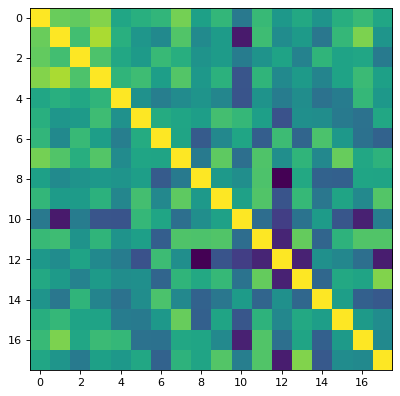

Model performance that is not cross-validated -0.33880712326115603


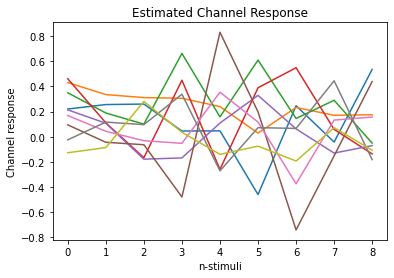

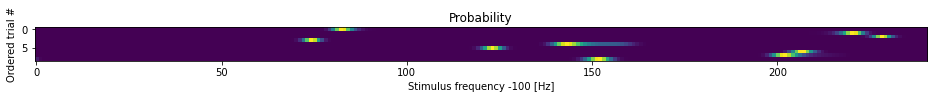

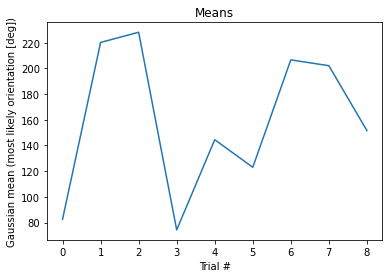

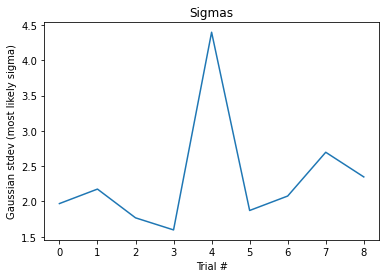

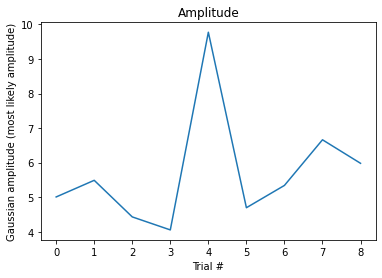

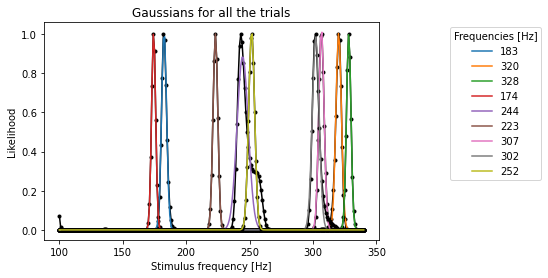

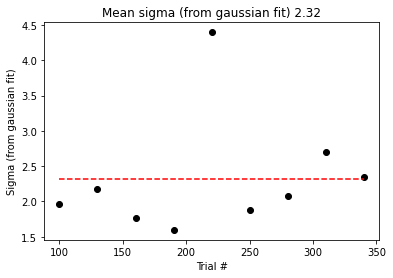

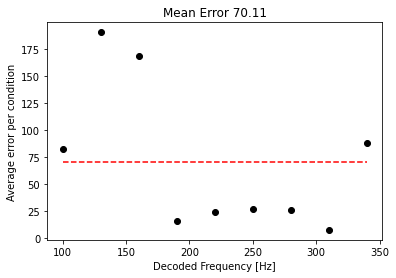

In [18]:
# Condition 3
B_test = m1_c3[mask_both].T # testVoxelResponse (B2) [txv]

# Note the model accepts the B matrix where the BOLD coefficients for the same trial
# condition are consecutive. So we have to change the shape of this `m1` and `m2` to satisfy this condition.
# `[B] = nStimuli*nRepeats, nVoxels` alternating the value of one fold with the value for that same trial of the other fold.
B = np.array([
    [B_test[i//2][k] if i % 2 == 0 else B_train[i//2][k] for i in range(B_test.shape[0] * 2)]
    for k in range(B_train.shape[1])]).T
print(B.shape) # Should be 18*268


C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, average_error_per_condition = simulation(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency)

initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec)
other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, average_error_per_condition)

(45, 268)


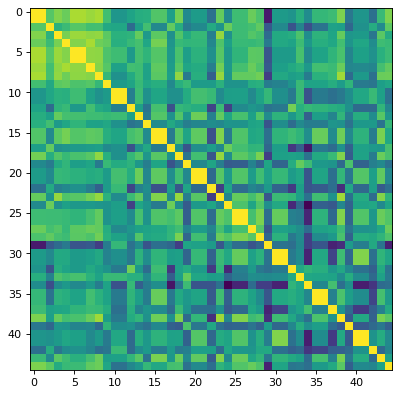

In [19]:
# Self similarity plot across the Pearson correlation coeffcients of these 5 voxel responses.

B_test0 = m1_c0[mask_both].T
B_test1 = m1_c1[mask_both].T # testVoxelResponse (B2) [txv]
B_test2 = m1_c2[mask_both].T # testVoxelResponse (B2) [txv]
B_test3 = m1_c3[mask_both].T # testVoxelResponse (B2) [txv]

# # Note the model accepts the B matrix where the BOLD coefficients for the same trial
# # condition are consecutive. So we have to change the shape of this `m1` and `m2` to satisfy this condition.
# # `[B] = nStimuli*nRepeats, nVoxels` alternating the value of one fold with the value for that same trial of the other fold.
B = np.array([
    [B_train[i//5][k] if i%5==0 else B_test0[i//5][k] if i%5==1 else B_test1[i//5][k] if i%5==2 else B_test2[i//5][k] if i%5==3 else B_test3[i//5][k]
     for i in range(B_test0.shape[0] * 5)]
    for k in range(B_test0.shape[1])]).T
print(B.shape)

nTrials = B.shape[0]
matrix = np.zeros([nTrials, nTrials])

for i in range(nTrials):
    for j in range(nTrials):
        matrix[i, j] = pearsonr(B[i,:], B[j,:])[0]    

plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(matrix)
plt.show()

# Goal 3: Train the model on the 2 folds of attentio-spatial condition 0.
Decode the stimulus likelihoods of the other 3 attentio-spatial conditions. Obtain the error per frequency and the mean error. Obtain the sigmas. Is there any difference across conditions?


### Training the model on the 2 folds of condition 1.

In [15]:
B_train1 = m1_c0[mask_both].T # trainVoxelResponse (B1) [txv]
B_train2 = m1_c0[mask_both].T # trainVoxelResponse (B1) [txv]


# Note the model accepts the B matrix where the BOLD coefficients for the same trial
# condition are consecutive. So we have to change the shape of this `m1` and `m2` to satisfy this condition.
# `[B] = nStimuli*nRepeats, nVoxels` alternating the value of one fold with the value for that same trial of the other fold.
# B_train = np.array([
#     [B_train1[i//2][k] if i % 2 == 0 else B_train2[i//2][k] for i in range(B_train1.shape[0] * 2)]
#     for k in range(B_train1.shape[1])]).T
# print(B_train.shape) 

In [16]:
# training the model on the 2 folds of condition 1.

# Initializing variables
nStimuli = 9
# nFolds = 1 # These are the number of overall BOLD coefficients in the big matrix. At least the same as nFolds.
# nNeurons = 120
# sigma = 10
# noiseStandardDeviation = 0.1 # 0.4
nVoxels = m1_c0[mask_both].shape[0] # number of voxels

nChannels = 9 # Note how in this particular case, nStimuli = nChannels = 8
exponent = 7

nfrequencies = 241
initial_frequency = 100
print("nVoxels", nVoxels)


# Simulating tactile stimuli
tactile_stimuli = [i*30+initial_frequency for i in range(nStimuli)]
stimuli = np.asarray([tactile_stimuli[i//2] for i in range(len(tactile_stimuli)*2)])

frequency_range = np.arange(initial_frequency, initial_frequency+nfrequencies) # Neurons tuned from 100-340 Hz frequencies


channelBasis, C = create_channel_basis(nChannels, exponent, nStimuli)
print("Data ready.")
W_estimated2, B_predicted2 = model_fit(C, B_train2)
W_estimated1, B_predicted1 = model_fit(C, B_train1)

# Obtaining the mean across the 2 folds
W_estimated = (W_estimated1 + W_estimated2)/2
B_predicted = (B_predicted1 + B_predicted2)/2
print("Model fit ready.")

#     W_estimated = np.matmul(np.linalg.pinv(C), B_train) # Computes the (Moore-Penrose) pseudo-inverse of C1
#     B_predicted = np.matmul(C, W_estimated) # model prediction on test data

nVoxels 268
Data ready.
Model fit ready.


### Test the model

In [17]:
# B_test data
B_test = m1_c1[mask_both].T # testVoxelResponse (B2) [txv]

In [18]:
C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, average_error_per_condition = simulation(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency)

Gaussian fit ready.
Error calculation ready.
--- 7.784571886062622 seconds ---


In [19]:
# B = np.array([
#     [B_test[i//2][k] if i % 2 == 0 else B_train[i//2][k] for i in range(B_test.shape[0] * 2)]
#     for k in range(B_train.shape[1])]).T
# print(B.shape) # Should be 18*268

B = np.array([
    [B_train1[i//3][k] if i % 3 == 0 else B_train2[i//3][k] if i % 3 == 1 else B_test[i//3][k]
     for i in range(B_train1.shape[0] * 3)]
    for k in range(B_train1.shape[1])]).T


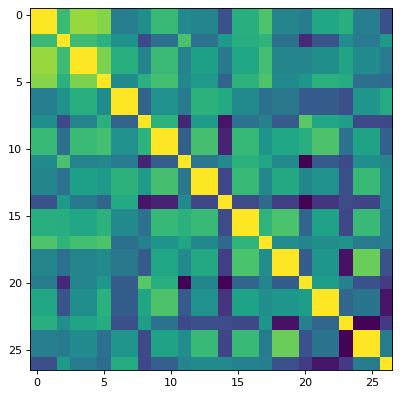

Model performance that is not cross-validated -0.2175391054361122


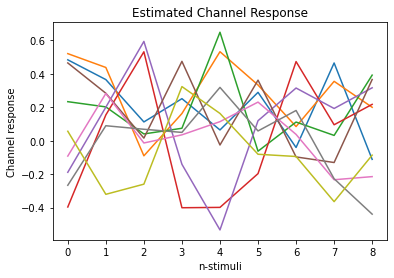

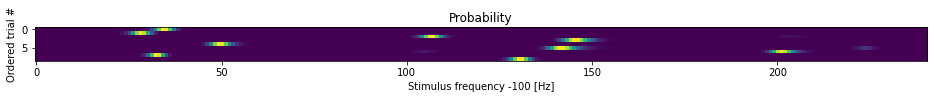

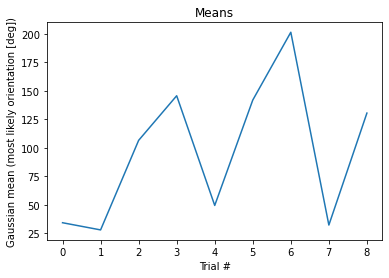

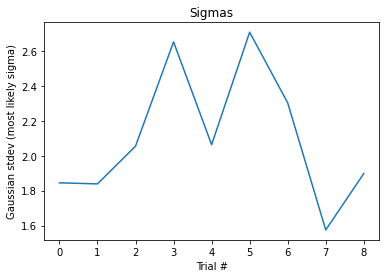

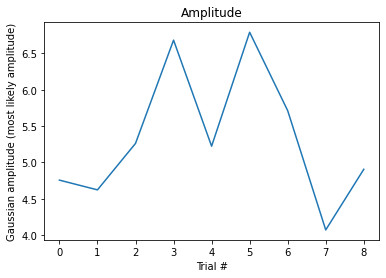

In [20]:
initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec)

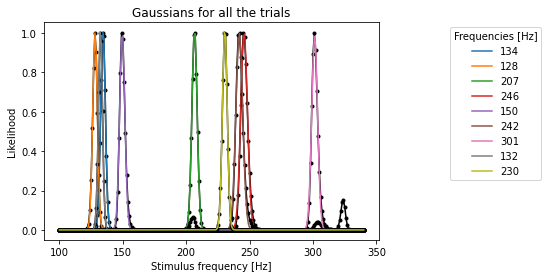

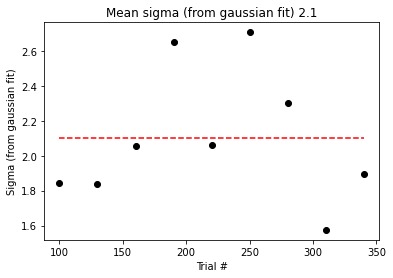

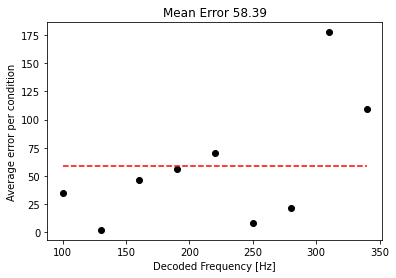

In [21]:
other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, average_error_per_condition)

### Now, for condition 2

In [22]:
# B_test data

B_test = m1_c2[mask_both].T # testVoxelResponse (B2) [txv]

B = np.array([
    [B_train1[i//3][k] if i % 3 == 0 else B_train2[i//3][k] if i % 3 == 1 else B_test[i//3][k]
     for i in range(B_train1.shape[0] * 3)]
    for k in range(B_train1.shape[1])]).T

In [23]:
C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, average_error_per_condition = simulation(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency)

Gaussian fit ready.
Error calculation ready.
--- 9.165442943572998 seconds ---


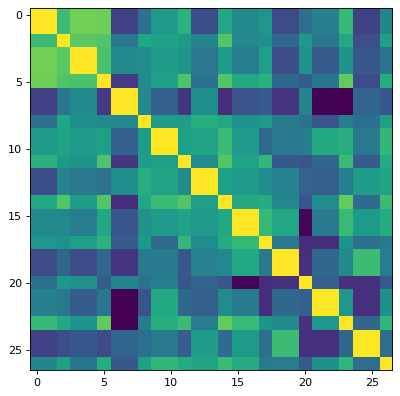

Model performance that is not cross-validated 0.2815837794825887


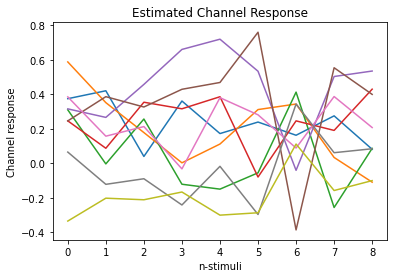

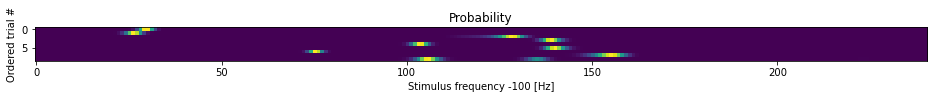

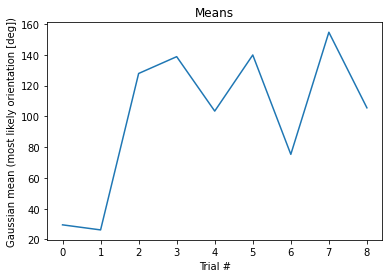

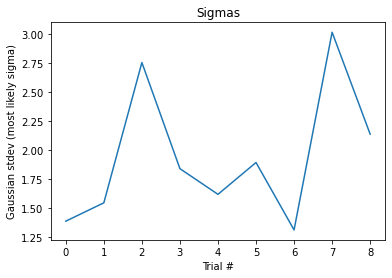

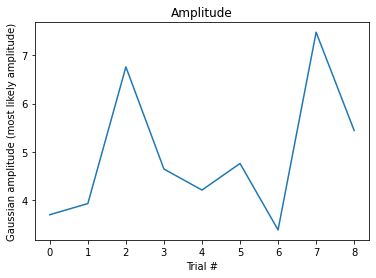

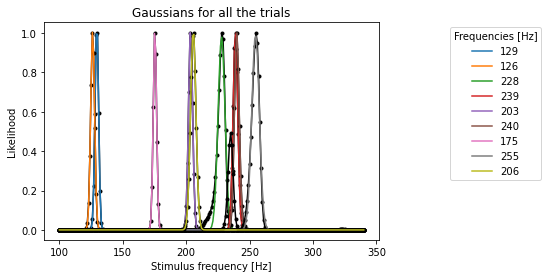

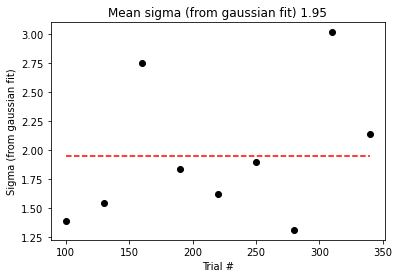

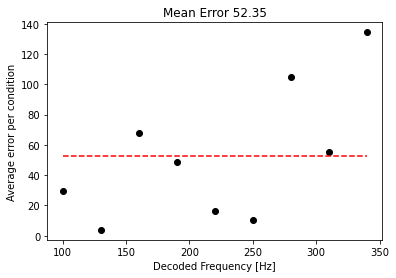

In [24]:
initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec)
other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, average_error_per_condition)

### Now, for condition 3

In [25]:
# B_test data
B_test = m1_c3[mask_both].T # testVoxelResponse (B2) [txv]

B = np.array([
    [B_train1[i//3][k] if i % 3 == 0 else B_train2[i//3][k] if i % 3 == 1 else B_test[i//3][k]
     for i in range(B_train1.shape[0] * 3)]
    for k in range(B_train1.shape[1])]).T

In [26]:
C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, average_error_per_condition = simulation(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency)

Gaussian fit ready.
Error calculation ready.
--- 6.6485090255737305 seconds ---


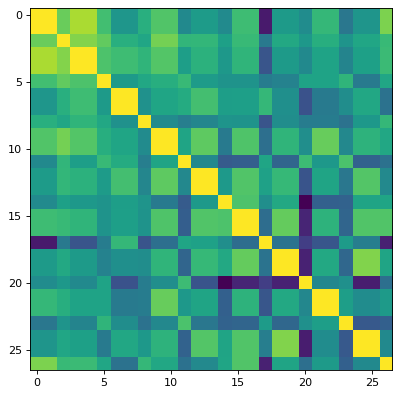

Model performance that is not cross-validated -0.33880712326115603


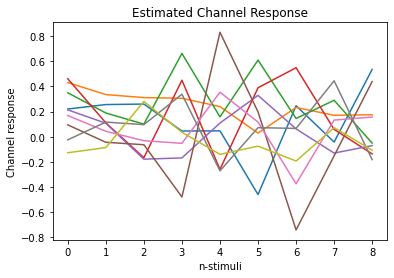

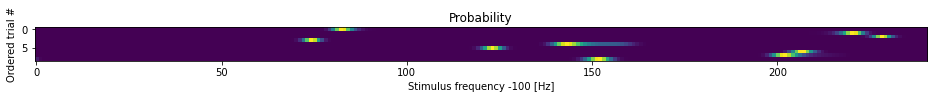

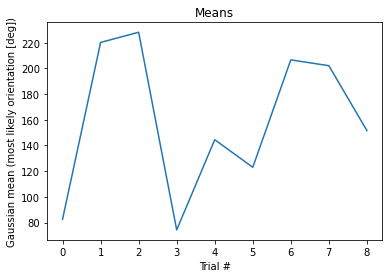

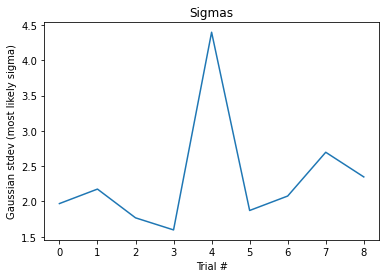

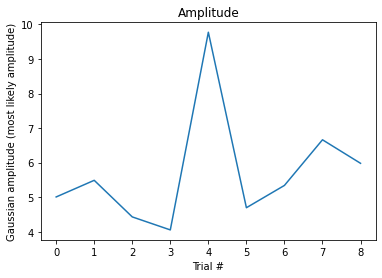

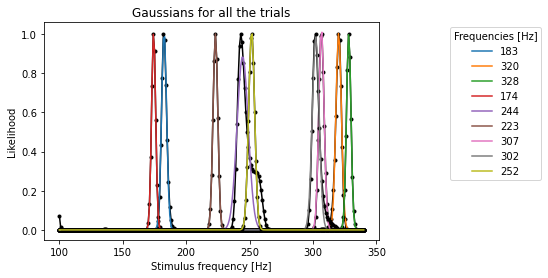

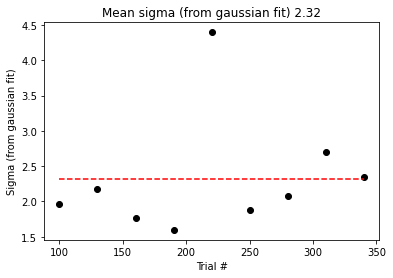

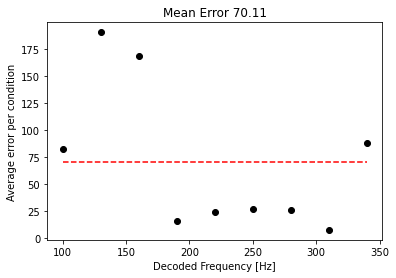

In [27]:
initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec)
other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, average_error_per_condition)

# Goal 2: Train the model on 4 X 1-folds of all the 4 conditions.

But brother, with the mask of voxels we are currently using, this will be noisy as F!